# The `opencadd.structure.subpockets` module

Let's walk through the functionalities offered in the `opencadd.structure.subpockets` module.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import time

import pandas as pd

from opencadd.structure.subpockets.parser import Mol2ToDataFrame
from opencadd.structure.subpockets.core import Pocket, Subpocket, Region, AnchorResidue

## Load structural data as `DataFrame`

In [3]:
# 4wsq_altA_chainA
MOL2_PATH = "/home/dominique/Desktop/protein.mol2"

In [4]:
parser = Mol2ToDataFrame()
protein_df = parser.from_file(MOL2_PATH)
protein_df.head()

,atom.id,atom.name,atom.x,atom.y,atom.z,atom.type,residue.subst_id,residue.subst_name,atom.charge,atom.backbone,residue.name,residue.pdb_id
0,1,N,10.2784,4.1662,49.9484,N.4,1,GLY29,1.0,BACKBONE,GLY,29
1,2,H1,10.2440,3.1868,50.1927,H,1,GLY29,0.0,BACKBONE,GLY,29
2,3,H2,9.9911,4.2838,48.9873,H,1,GLY29,0.0,BACKBONE,GLY,29
3,4,H3,9.6568,4.6858,50.5515,H,1,GLY29,0.0,BACKBONE,GLY,29
4,5,CA,11.6355,4.6586,50.1118,C.3,1,GLY29,0.0,BACKBONE,GLY,29


## Pocket

The `Pocket` class currently holds the following attributes/properties:

- `data`: a `DataFrame` containing the structural data of the full protein or the pocket
- `name`: the protein/pocket name
- `subpockets`: subpockets defined based on a set of anchor residues each
- `regions`: user-defined regions that are of importance for the protein/pocket

In [5]:
klifs_region_colors = {
    "I": "khaki",
    "g.l": "green",
    "II": "khaki",
    "III": "khaki",
    "αC": "red",
    "b.l": "green",
    "IV": "khaki",
    "V": "khaki",
    "GK": "orange",
    "hinge": "magenta",
    "linker": "cyan",
    "αD": "red",
    "αE": "red",
    "VI": "khaki",
    "c.l": "darkorange",
    "VII": "khaki",
    "VIII": "khaki",
    "xDFG": "cornflowerblue",
    "a.l": "cornflowerblue"
}

In [6]:
from bravado.client import SwaggerClient

KLIFS_API_DEFINITIONS = "http://klifs.vu-compmedchem.nl/swagger/swagger.json"
KLIFS_CLIENT = SwaggerClient.from_url(KLIFS_API_DEFINITIONS, config={"validate_responses": False})


result = KLIFS_CLIENT.Interactions.get_interactions_match_residues(structure_ID=3834).response().result
pocket_mapping = pd.DataFrame(result)
pocket_mapping = pocket_mapping.rename(columns={"index": "residue.klifs_id", "Xray_position": "residue.pdb_id", "KLIFS_position": "residue.klifs_region"})
pocket_mapping["residue.klifs_region"] = pocket_mapping["residue.klifs_region"].apply(lambda x: ".".join(x.split(".")[:-1]))
pocket_mapping["residue.color"] = pocket_mapping["residue.klifs_region"].apply(lambda x: klifs_region_colors[x])

pocket_mapping

,residue.klifs_id,residue.pdb_id,residue.klifs_region,residue.color
0,1,50,I,khaki
1,2,51,I,khaki
2,3,52,I,khaki
3,4,53,g.l,green
4,5,54,g.l,green
...,...,...,...,...
80,81,194,xDFG,cornflowerblue
81,82,195,xDFG,cornflowerblue
82,83,196,xDFG,cornflowerblue
83,84,197,a.l,cornflowerblue


In [7]:
pocket_residue_pdb_ids = pocket_mapping["residue.pdb_id"].to_list()
pocket_residue_labels = pocket_mapping["residue.klifs_id"].to_list()

### Initialize pocket

We initialize the pocket with its name and the pocket/protein structural data.

In [8]:
pocket = Pocket(protein_df, "example kinase", pocket_residue_pdb_ids, pocket_residue_labels)

In [9]:
pocket.residues

,residue.pdb_id,residue.labels
0,50,1
1,51,2
2,52,3
3,53,4
4,54,5
...,...,...
80,194,81
81,195,82
82,196,83
83,197,84


We have not set any subpockets or regions (`None`), yet:

In [10]:
pocket.subpockets

In [11]:
pocket.regions

In [12]:
try: 
    Pocket(protein_df, "example kinase", [1, 2, 3], [1, 2])
except ValueError as e:
    print(e)

Number of residue PDB IDs and labels must be of same length.


### Add pocket centroid

In [13]:
pocket.add_centroid()

The pocket centroid is calculated based on 85 CA atoms.


In [14]:
pocket.centroid

array([ 1.13481647, 20.79171176, 36.30449647])

### Add subpockets

Next, we can add subpockets one-by-one to the pocket. For each subpocket we define the following:
- a subpocket __name__, 
- a subpocket __color__, 
- the __residue PDB IDs__ of all __anchor residues__, i.e. the residues determining the subpocket center (centroid of all anchor residues' CA atoms) and 
- optionally __residue labels__ for all __anchor residues__, e.g. if we want to pass an alignment ID to each residue.

The class method `add_subpocket` uses the `Subpocket` class.

In [15]:
pocket.add_subpocket("hinge_region", "magenta", [73, 128, 193], [16, 47, 80])
pocket.add_subpocket("dfg_region", "cornflowerblue", [76, 90, 194], [19, 24, 81])
pocket.add_subpocket("front_pocket", "cyan", [55, 129, 181], [6, 48, 75])

Using the `Pocket`'s property `subpockets`, we get an overview of all specified subpockets.

In [16]:
pocket.subpockets

,subpocket.name,subpocket.color_name,subpocket.color_rgb,subpocket.center
0,hinge_region,magenta,"(1.0, 0.0, 1.0)","[1.9576333333333336, 21.923766666666666, 41.69..."
1,dfg_region,cornflowerblue,"(0.39215686274509803, 0.5843137254901961, 0.92...","[7.613366666666667, 20.0352, 33.4246]"
2,front_pocket,cyan,"(0.0, 1.0, 1.0)","[-0.5543666666666666, 15.943933333333334, 39.5..."


Using the `Pocket`'s property `anchor_residues`, we get an overview of all subpockets' anchor residues.

In [17]:
pocket.anchor_residues

,subpocket.name,subpocket.color_name,subpocket.color_rgb,anchor_residue.pdb_id,anchor_residue.pdb_id_alternative,anchor_residue.label,anchor_residue.center
0,hinge_region,magenta,"(1.0, 0.0, 1.0)",73,None,16,"[7.675, 21.5254, 43.5183]"
1,hinge_region,magenta,"(1.0, 0.0, 1.0)",128,None,47,"[-0.3245, 23.4828, 45.9722]"
2,hinge_region,magenta,"(1.0, 0.0, 1.0)",193,None,80,"[-1.4776, 20.7631, 35.5796]"
0,dfg_region,cornflowerblue,"(0.39215686274509803, 0.5843137254901961, 0.92...",76,None,19,"[13.7391, 16.4906, 37.1612]"
1,dfg_region,cornflowerblue,"(0.39215686274509803, 0.5843137254901961, 0.92...",90,None,24,"[7.5673, 24.3155, 29.4688]"
2,dfg_region,cornflowerblue,"(0.39215686274509803, 0.5843137254901961, 0.92...",194,None,81,"[1.5337, 19.2995, 33.6438]"
0,front_pocket,cyan,"(0.0, 1.0, 1.0)",55,None,6,"[5.5627, 10.2881, 37.6314]"
1,front_pocket,cyan,"(0.0, 1.0, 1.0)",129,None,48,"[-3.6779, 21.6755, 45.6664]"
2,front_pocket,cyan,"(0.0, 1.0, 1.0)",181,None,75,"[-3.5479, 15.8682, 35.3866]"


### Add regions

The `Pocket` class also allows to specify pocket regions, normally used to store key regions, such as the hinge region or the catalytic loop in kinases. This information can be used for pocket visualization.

The class method `add_regions` uses the `Regions` class.

In [18]:
for (region, color), group in pocket_mapping.groupby(["residue.klifs_region", "residue.color"]):
    pocket.add_region(region, color, group["residue.pdb_id"].to_list(), group["residue.klifs_id"].to_list())

In [19]:
pocket.regions

,region.name,region.color_name,region.color_rgb,residue.pdb_id,residue.label
0,GK,orange,"(1.0, 0.6470588235294118, 0.0)",126,45
0,I,khaki,"(0.9411764705882353, 0.9019607843137255, 0.549...",50,1
1,I,khaki,"(0.9411764705882353, 0.9019607843137255, 0.549...",51,2
2,I,khaki,"(0.9411764705882353, 0.9019607843137255, 0.549...",52,3
0,II,khaki,"(0.9411764705882353, 0.9019607843137255, 0.549...",59,10
...,...,...,...,...,...
0,αE,red,"(1.0, 0.0, 0.0)",166,60
1,αE,red,"(1.0, 0.0, 0.0)",167,61
2,αE,red,"(1.0, 0.0, 0.0)",168,62
3,αE,red,"(1.0, 0.0, 0.0)",169,63


### Visualize pocket

In [22]:
view = pocket.visualize(MOL2_PATH)
view

NGLWidget()

In [23]:
time.sleep(15)

In [24]:
view.render_image(),

(Image(value=b'', width='99%'),)

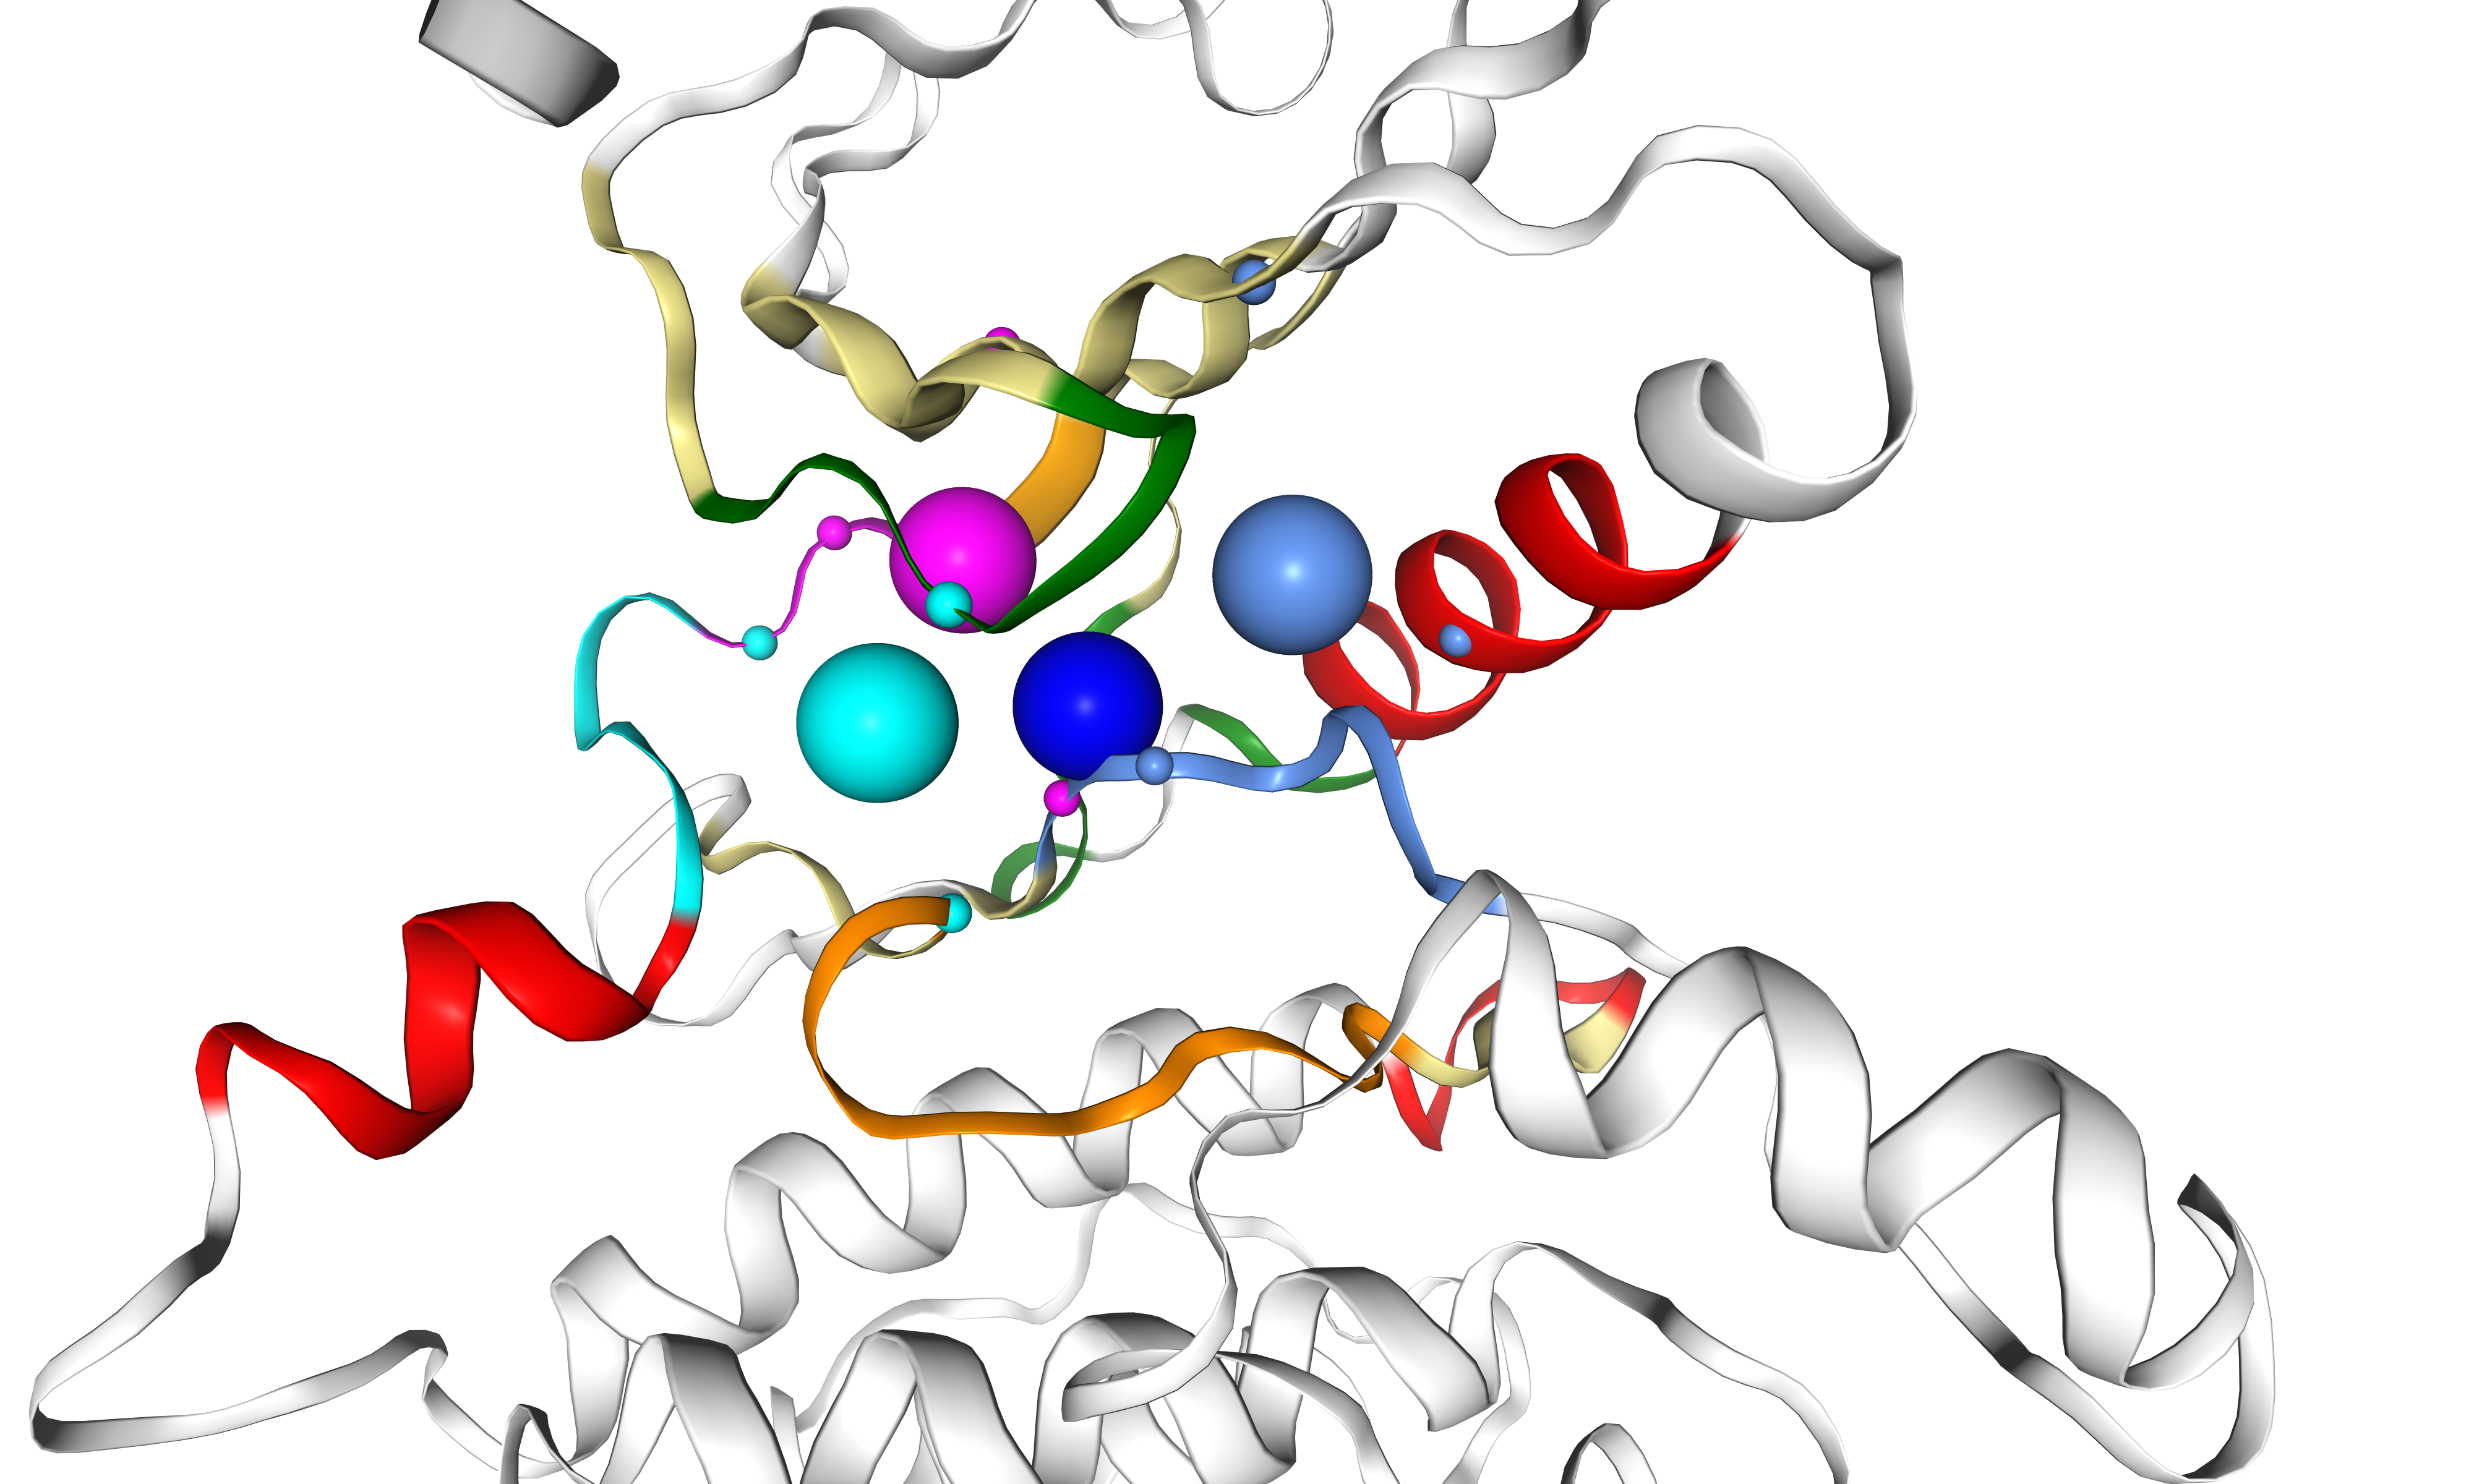

In [44]:
# Static output
view._display_image()

## Subpocket

It is also possible to define a single subpocket, using the `Subpocket` class directly.

In [27]:
subpocket = Subpocket()
subpocket.from_dataframe(protein_df, "hinge_region", "magenta", [73, 128, 193], [16, 47, 80])

Get the subpocket name and color.

In [28]:
print(subpocket.name)
print(subpocket.color_name)
print(subpocket.color_rgb)

hinge_region
magenta
(1.0, 0.0, 1.0)


Get the subpocket center.

In [29]:
subpocket.center

array([ 1.95763333, 21.92376667, 41.69003333])

Get details on all anchor residues used to calculate the subpocket center.

In [30]:
a = subpocket._anchor_residues[0]

In [31]:
a.color_name

'magenta'

In [32]:
a.center

array([ 7.675 , 21.5254, 43.5183])

In [33]:
subpocket.anchor_residues

,subpocket.name,subpocket.color_name,subpocket.color_rgb,anchor_residue.pdb_id,anchor_residue.pdb_id_alternative,anchor_residue.label,anchor_residue.center
0,hinge_region,magenta,"(1.0, 0.0, 1.0)",73,None,16,"[7.675, 21.5254, 43.5183]"
1,hinge_region,magenta,"(1.0, 0.0, 1.0)",128,None,47,"[-0.3245, 23.4828, 45.9722]"
2,hinge_region,magenta,"(1.0, 0.0, 1.0)",193,None,80,"[-1.4776, 20.7631, 35.5796]"


## Region

It is also possible to define a single region, using the `Region` class directly.

In [34]:
region = Region()
region.from_dataframe(protein_df, "hinge", "magenta", list(range(127, 130)), list(range(46, 49)))

Get the region's name and color.

In [35]:
print(region.name)
print(region.color_name)
print(region.color_rgb)

hinge
magenta
(1.0, 0.0, 1.0)


Get the region's residue PDB IDs and optionally residue labels (without input residue PDB IDs that are not part of the protein/pocket).

In [36]:
print(region.residue_pdb_ids)
print(region.residue_labels)

['127', '128', '129']
['46', '47', '48']


## Anchor residue

The `AnchorResidue` class holds

In [37]:
dataframe = pd.DataFrame(
    {"residue.pdb_id": ["1", "2", "3", "7", "8", "9", "11"],
     "atom.name": ["CA", "CA", "CA", "CA", "CA", "CA", "CA"],
     "atom.x": [1.0, 2.0, 3.0, 4.0, 20.0, 30.0, 40.0],
     "atom.y": [1.0, 2.0, 3.0, 4.0, 20.0, 30.0, 40.0],
     "atom.z": [1.0, 2.0, 3.0, 4.0, 20.0, 30.0, 40.0]
    }
)
dataframe

,residue.pdb_id,atom.name,atom.x,atom.y,atom.z
0,1,CA,1.0,1.0,1.0
1,2,CA,2.0,2.0,2.0
2,3,CA,3.0,3.0,3.0
3,7,CA,4.0,4.0,4.0
4,8,CA,20.0,20.0,20.0
5,9,CA,30.0,30.0,30.0
6,11,CA,40.0,40.0,40.0


### Test behaviour for missing anchor residue

In [38]:
def test_anchor_residue_behaviour(dataframe, residue_pdb_id):
    residue = AnchorResidue()
    residue.from_dataframe(dataframe, residue_pdb_id)
    print("Input residue:       ", residue.pdb_id)
    print("Alternative residue: ", residue.pdb_id_alternative)
    print("Residue center:      ", residue.center)

The determination of anchor residues depends on the CA atom availablity of the user-defined anchor residue as well as the residue before and after.

#### Case 1: Anchor residue available

In [39]:
test_anchor_residue_behaviour(dataframe, "1")

Input residue:        1
Alternative residue:  None
Residue center:       [1. 1. 1.]


#### Case 2: Anchor residue not available, but residues before and after

In [40]:
test_anchor_residue_behaviour(dataframe, "10")

Input residue:        10
Alternative residue:  ['9', '11']
Residue center:       [35. 35. 35.]


#### Case 3: Anchor residue not available, but residues before (not after)

In [41]:
test_anchor_residue_behaviour(dataframe, "4")

Input residue:        4
Alternative residue:  ['3']
Residue center:       [3. 3. 3.]


#### Case 4: Anchor residue not available, but residues after (not before)

In [42]:
test_anchor_residue_behaviour(dataframe, "6")

Input residue:        6
Alternative residue:  ['7']
Residue center:       [4. 4. 4.]


#### Case 5: Anchor residue and residues before and after not available

In [43]:
test_anchor_residue_behaviour(dataframe, "5")

Input residue:        5
Alternative residue:  None
Residue center:       None
